In [157]:
# Import necessary libraries
import pandas as pd # for data processing
import numpy as np # here mostly for series generation

import matplotlib.pyplot as plt # for vizualization
import matplotlib.dates as mdates # for data formatting when visualizing
import matplotlib.ticker as ticker # for more advanced axis formatting

import seaborn as sns


import statsmodels.api as sm # for linear regression model, OLS estimation
import statsmodels.stats.diagnostic as smd # for Breusch-Godfrey test

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.api import VAR, VECM
from statsmodels.api import OLS
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # ACF, PACF plots
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.vector_ar.vecm import select_order, select_coint_rank, coint_johansen
from statsmodels.stats.stattools import jarque_bera

from scipy.stats import norm

from IPython.display import Markdown

import yfinance as yf # for importing data directly from finance.yahoo.com

import warnings
warnings.simplefilter("ignore", category="UserWarning")
warnings.simplefilter("ignore", category="ValueWarning")

# Set global options
pd.options.display.float_format = '{:.10f}'.format
sns.set_theme(style="whitegrid")

# Set plotting style
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
warnings.filterwarnings("ignore")

In [158]:
# Adjust path relative to the notebook location
file_path = 'data/TSA_2025_project_data_1.csv'
df = pd.read_csv(file_path)
train_df = df.iloc[:575]
test_df = df.loc[575:]
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

In [159]:
print(df.columns)

Index(['y1', 'y2', 'y3', 'y4', 'y5', 'y6', 'y7', 'y8', 'y9', 'y10'], dtype='object')


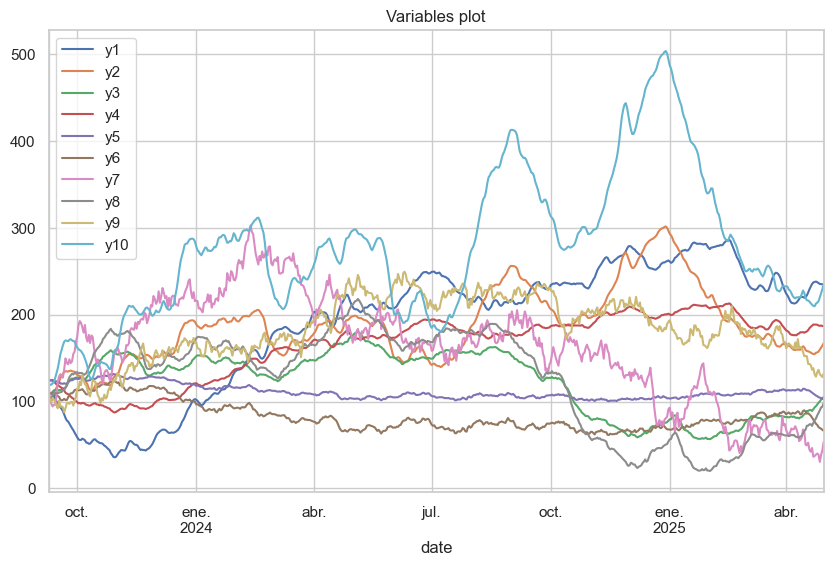

In [160]:
df[['y1', 'y2', 'y3', 'y4', 'y5', 'y6', 'y7', 'y8', 'y9', 'y10']].plot(figsize=(10, 6), title="Variables plot")
plt.show()

With no test yet we can appreciete a similar tendency on the variables [y2 and y10], [y3 and y8] and [y5 and y6] 

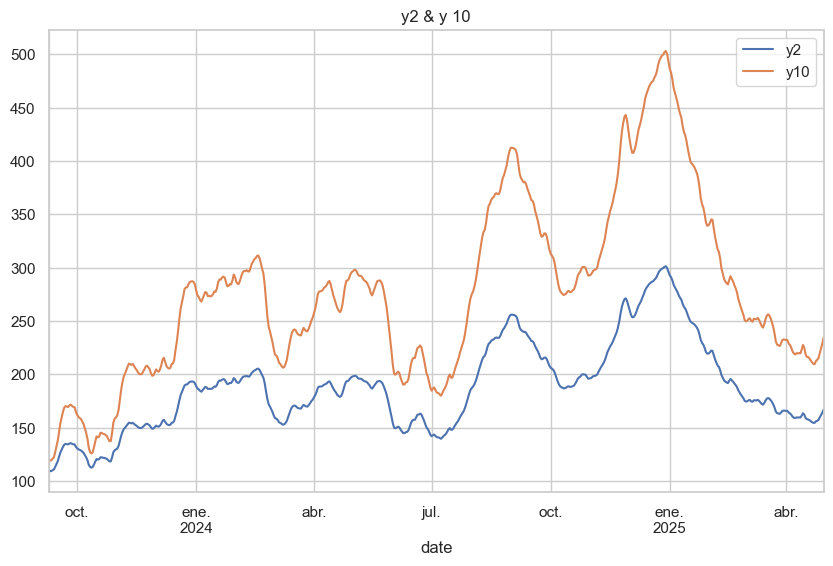

In [161]:
df[['y2','y10']].plot(figsize=(10, 6), title="y2 & y 10")
plt.show()

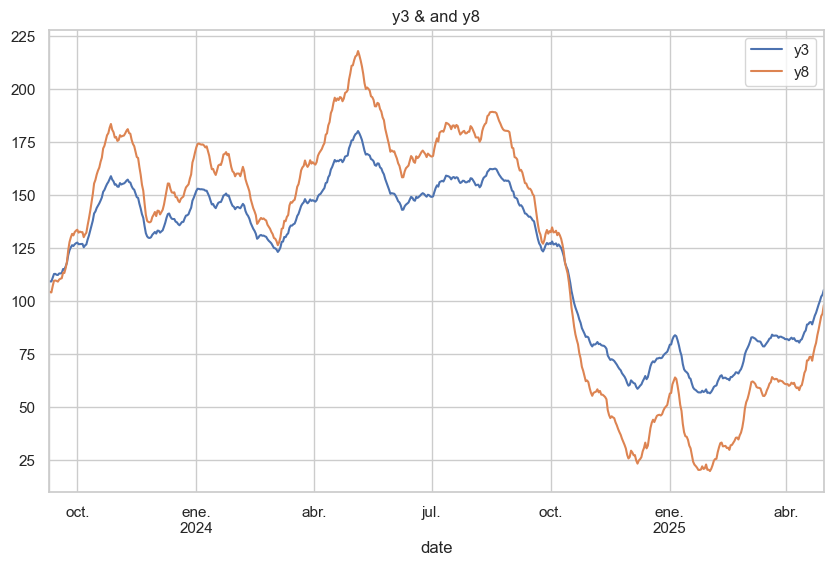

In [162]:
df[['y3', 'y8']].plot(figsize=(10, 6), title="y3 & and y8")
plt.show()

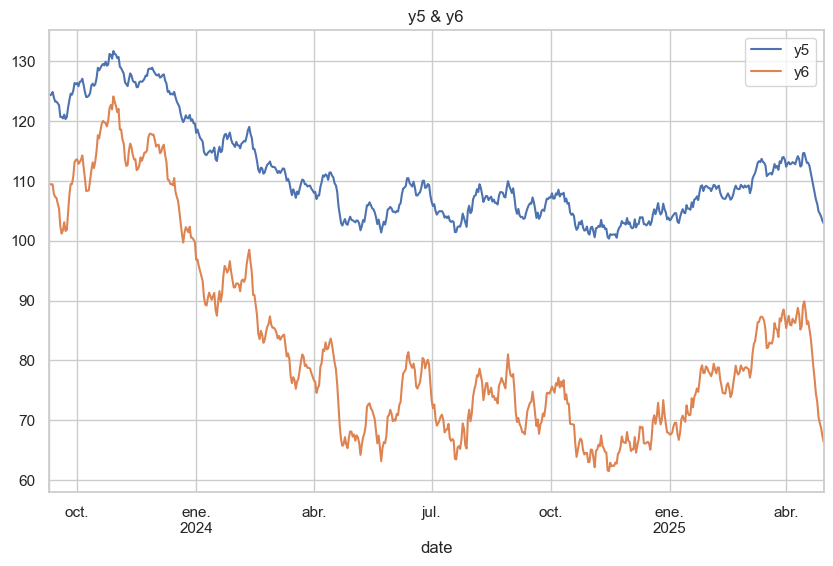

In [163]:
df[['y5', 'y6']].plot(figsize=(10, 6), title="y5 & y6")
plt.show()

In [170]:
diff_df = train_df[['y1', 'y2', 'y3', 'y4', 'y5', 'y6', 'y7', 'y8', 'y9', 'y10']].diff()

for col in diff_df.columns:
    train_df[f'd{col}'] = diff_df[col]

In [172]:
train_df.head()

,date,y1,y2,y3,y4,y5,y6,y7,y8,y9,...,dy1,dy2,dy3,dy4,dy5,dy6,dy7,dy8,dy9,dy10
0,2023-09-09,109.4100000000,109.4100000000,109.4100000000,124.2400000000,124.4700000000,109.4100000000,119.9400000000,104.6600000000,107.6200000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-09-10,109.4100000000,109.4100000000,109.4100000000,124.2100000000,124.3200000000,109.4100000000,101.3900000000,104.3400000000,102.6100000000,...,0.0000000000,0.0000000000,0.0000000000,-0.0300000000,-0.1500000000,0.0000000000,-18.5500000000,-0.3200000000,-5.0100000000,0.0400000000
2,2023-09-11,109.4200000000,109.4100000000,109.4100000000,124.4100000000,124.3700000000,109.4100000000,97.6400000000,104.2300000000,99.1600000000,...,0.0100000000,0.0000000000,0.0000000000,0.2000000000,0.0500000000,0.0000000000,-3.7500000000,-0.1100000000,-3.4500000000,0.0200000000
3,2023-09-12,108.6800000000,110.1900000000,111.1200000000,123.9300000000,124.8200000000,109.4100000000,94.3500000000,107.2300000000,103.3900000000,...,-0.7400000000,0.7800000000,1.7100000000,-0.4800000000,0.4500000000,0.0000000000,-3.2900000000,3.0000000000,4.2300000000,1.6800000000
4,2023-09-13,106.2100000000,110.8800000000,112.9200000000,122.6800000000,123.9100000000,107.8400000000,96.2200000000,109.7100000000,102.4300000000,...,-2.4700000000,0.6900000000,1.8000000000,-1.2500000000,-0.9100000000,-1.5700000000,1.8700000000,2.4800000000,-0.9600000000,1.1100000000


## 1. Test for Cointegration

In [173]:
def adf_test(series, max_lag=5):
    result = adfuller(series.dropna(), maxlag=max_lag, autolag=None)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if result[0] < result[4]["5%"]:
        print ("Reject Ho - Time Series is Stationary")
    else:
        print ("Failed to Reject Ho - Time Series is Non-Stationary")

In [174]:
X = train_df["y2"].values
adf_test(df["y2"])

ADF Statistic: -2.384781
p-value: 0.146078
Critical Values:
	1%: -3.441
	5%: -2.866
	10%: -2.569
Failed to Reject Ho - Time Series is Non-Stationary


In [175]:
X = train_df["y10"].values
adf_test(train_df["y10"])

ADF Statistic: -2.250023
p-value: 0.188593
Critical Values:
	1%: -3.442
	5%: -2.867
	10%: -2.569
Failed to Reject Ho - Time Series is Non-Stationary


In [176]:
X = train_df["dy2"].values
adf_test(train_df["dy2"])

ADF Statistic: -6.574744
p-value: 0.000000
Critical Values:
	1%: -3.442
	5%: -2.867
	10%: -2.569
Reject Ho - Time Series is Stationary


In [177]:
X = train_df["dy10"].values
adf_test(train_df["dy10"])

ADF Statistic: -6.511367
p-value: 0.000000
Critical Values:
	1%: -3.442
	5%: -2.867
	10%: -2.569
Reject Ho - Time Series is Stationary


Both variables are $\sim I(1)$, so in the next step we can check whether they are **cointegrated**.

In [178]:
def adf_test(series, max_aug=10, version='c'):
    
    results = []

    y = series.diff()
    X = pd.DataFrame({'y_lag': series.shift()})

    if version == 'c' or version == 't': # constant to be added optionally 
        X = sm.add_constant(X)
    if version == 't': # (deterministic) trend component to be added optionally
        X['trend'] = range(len(X))

    for i in range(0, max_aug): # iterating through different numbers of augmentations
        
        for aug in range(1, i+1): # adding augmentations max_aug is reached
            X['aug_'+str(aug)] = y.shift(aug)

        model = sm.OLS(series.diff(), X, missing='drop').fit() # fitting a linear regression with OLS

        ts = model.tvalues['y_lag'] # test statistic
        nobs = model.nobs # number of observations

        if version == 'n': # critical values for basic version of ADF
            if nobs > 100:
                cv01 = -2.567; cv05 = -1.941; cv10 = -1.616 # critical values for more than 500 observations
            else:
                cv01 = np.nan; cv05 = np.nan; cv10 = np.nan # if number of observations is lower than 500, we should check the critical values manually
        if version == 'c': # critical values for version with constant
            if nobs > 100:
                cv01 = -3.434; cv05 = -2.863; cv10 = -2.568 # critical values for more than 500 observations
            else:
                cv01 = np.nan; cv05 = np.nan; cv10 = np.nan # if number of observations is lower than 500, we should check the critical values manually
        if version == 't': # critical values for version with constant and (deterministic) trend component
            if nobs > 100:
                cv01 = -3.963; cv05 = -3.413; cv10 = -3.128 # critical values for more than 500 observations
            else:
                cv01 = np.nan; cv05 = np.nan; cv10 = np.nan # if number of observations is lower than 500, we should check the critical values manually

        bg_test01 = smd.acorr_breusch_godfrey(model, nlags=1);  bg_pvalue01 = round(bg_test01[1],4); bg_test01 = round(bg_test01[0],4); 
        bg_test05 = smd.acorr_breusch_godfrey(model, nlags=5);  bg_pvalue05 = round(bg_test05[1],4); bg_test05 = round(bg_test05[0],4); 
        bg_test10 = smd.acorr_breusch_godfrey(model, nlags=10); bg_pvalue10 = round(bg_test10[1],4); bg_test10 = round(bg_test10[0],4);
        bg_test15 = smd.acorr_breusch_godfrey(model, nlags=15); bg_pvalue15 = round(bg_test15[1],4); bg_test15 = round(bg_test15[0],4);

        results.append([i, ts, cv01, cv05, cv10, 
                        bg_test01, bg_pvalue01, bg_test05, bg_pvalue05, bg_test10, bg_pvalue10, bg_test15, bg_pvalue15])

    results_df = pd.DataFrame(results)
    results_df.columns = ['number of augmentations', 
                          'ADF test statistic', 'ADF critival value (1%)', 'ADF critival value (5%)', 'ADF critival value (10%)', 
                          'BG test (1 lag) (statistic)', 'BG test (1 lag) (p-value)', 
                          'BG test (5 lags) (statistic)', 'BG test (5 lags) (p-value)', 
                          'BG test (10 lags) (statistic)', 'BG test (10 lags) (p-value)', 
                          'BG test (15 lags) (statistic)', 'BG test (15 lags) (p-value)']
    
    return results_df

In [179]:
adf_test(train_df['y2'])

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-1.8822597171,-3.4340000000,-2.8630000000,-2.5680000000,425.7181000000,0.0000000000,449.7069000000,0.0000000000,452.5615000000,0.0000000000,453.1616000000,0.0000000000
1,1,-2.6157603140,-3.4340000000,-2.8630000000,-2.5680000000,47.3642000000,0.0000000000,97.9047000000,0.0000000000,102.8077000000,0.0000000000,104.6629000000,0.0000000000
2,2,-2.1496364941,-3.4340000000,-2.8630000000,-2.5680000000,26.6086000000,0.0000000000,57.3745000000,0.0000000000,60.4578000000,0.0000000000,62.2334000000,0.0000000000
3,3,-2.4049360991,-3.4340000000,-2.8630000000,-2.5680000000,12.3845000000,0.0004000000,33.3642000000,0.0000000000,38.7658000000,0.0000000000,40.0410000000,0.0004000000
4,4,-2.1935056626,-3.4340000000,-2.8630000000,-2.5680000000,12.8349000000,0.0003000000,25.2678000000,0.0001000000,30.1459000000,0.0008000000,31.6027000000,0.0073000000
5,5,-2.2673831114,-3.4340000000,-2.8630000000,-2.5680000000,5.9263000000,0.0149000000,12.6567000000,0.0268000000,16.7567000000,0.0799000000,17.6630000000,0.2808000000
6,6,-2.0950562734,-3.4340000000,-2.8630000000,-2.5680000000,2.4646000000,0.1164000000,3.1010000000,0.6844000000,8.1404000000,0.6151000000,9.6346000000,0.8421000000
7,7,-2.1268162270,-3.4340000000,-2.8630000000,-2.5680000000,0.0088000000,0.9254000000,4.4085000000,0.4922000000,6.5432000000,0.7677000000,8.2050000000,0.9153000000
8,8,-2.0161896703,-3.4340000000,-2.8630000000,-2.5680000000,0.0003000000,0.9869000000,0.2940000000,0.9978000000,8.5821000000,0.5722000000,10.2659000000,0.8027000000
9,9,-2.0628662544,-3.4340000000,-2.8630000000,-2.5680000000,0.7748000000,0.3787000000,4.3188000000,0.5045000000,6.0732000000,0.8091000000,9.5162000000,0.8490000000


In [180]:
adf_test(train_df['y10'])

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-1.8841970367,-3.4340000000,-2.8630000000,-2.5680000000,424.8320000000,0.0000000000,446.6175000000,0.0000000000,448.9251000000,0.0000000000,449.7937000000,0.0000000000
1,1,-2.6105197595,-3.4340000000,-2.8630000000,-2.5680000000,44.9137000000,0.0000000000,87.3367000000,0.0000000000,91.9624000000,0.0000000000,94.8094000000,0.0000000000
2,2,-2.1572125995,-3.4340000000,-2.8630000000,-2.5680000000,23.4591000000,0.0000000000,47.4175000000,0.0000000000,51.3834000000,0.0000000000,54.0694000000,0.0000000000
3,3,-2.3880321292,-3.4340000000,-2.8630000000,-2.5680000000,10.0651000000,0.0015000000,26.0485000000,0.0001000000,33.1850000000,0.0003000000,35.2355000000,0.0023000000
4,4,-2.2158434286,-3.4340000000,-2.8630000000,-2.5680000000,11.4985000000,0.0007000000,20.5542000000,0.0010000000,27.1344000000,0.0025000000,29.5367000000,0.0137000000
5,5,-2.2500225144,-3.4340000000,-2.8630000000,-2.5680000000,4.5137000000,0.0336000000,9.3863000000,0.0946000000,14.2728000000,0.1609000000,16.4127000000,0.3552000000
6,6,-2.1211851993,-3.4340000000,-2.8630000000,-2.5680000000,1.4136000000,0.2345000000,2.0948000000,0.8359000000,8.5889000000,0.5715000000,11.1112000000,0.7447000000
7,7,-2.1000681212,-3.4340000000,-2.8630000000,-2.5680000000,0.2525000000,0.6153000000,4.1009000000,0.5350000000,8.0809000000,0.6209000000,11.1190000000,0.7441000000
8,8,-2.0400696030,-3.4340000000,-2.8630000000,-2.5680000000,0.7993000000,0.3713000000,1.5940000000,0.9020000000,9.9952000000,0.4409000000,13.3483000000,0.5754000000
9,9,-2.0439985379,-3.4340000000,-2.8630000000,-2.5680000000,0.3369000000,0.5616000000,4.3649000000,0.4982000000,7.0440000000,0.7213000000,12.7791000000,0.6194000000


In [181]:
adf_test(train_df['dy2'])

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-6.5264261015,-3.4340000000,-2.8630000000,-2.5680000000,49.4348000000,0.0000000000,99.4710000000,0.0000000000,103.8406000000,0.0000000000,105.6099000000,0.0000000000
1,1,-8.5108319450,-3.4340000000,-2.8630000000,-2.5680000000,25.1371000000,0.0000000000,56.5251000000,0.0000000000,60.2453000000,0.0000000000,61.8927000000,0.0000000000
2,2,-6.4547703190,-3.4340000000,-2.8630000000,-2.5680000000,13.2432000000,0.0003000000,34.6242000000,0.0000000000,39.2896000000,0.0000000000,40.3723000000,0.0004000000
3,3,-7.2512492577,-3.4340000000,-2.8630000000,-2.5680000000,11.4218000000,0.0007000000,22.4273000000,0.0004000000,28.7420000000,0.0014000000,31.1664000000,0.0083000000
4,4,-6.0530363178,-3.4340000000,-2.8630000000,-2.5680000000,5.8534000000,0.0155000000,13.4716000000,0.0193000000,16.9595000000,0.0753000000,17.6737000000,0.2802000000
5,5,-6.5747441997,-3.4340000000,-2.8630000000,-2.5680000000,1.9583000000,0.1617000000,3.0217000000,0.6966000000,7.6603000000,0.6620000000,8.9673000000,0.8792000000
6,6,-5.9884128035,-3.4340000000,-2.8630000000,-2.5680000000,0.0331000000,0.8557000000,4.5996000000,0.4667000000,6.3734000000,0.7830000000,7.6892000000,0.9356000000
7,7,-5.9705493783,-3.4340000000,-2.8630000000,-2.5680000000,0.0100000000,0.9202000000,0.2143000000,0.9990000000,7.7447000000,0.6538000000,9.3393000000,0.8591000000
8,8,-5.5150496553,-3.4340000000,-2.8630000000,-2.5680000000,0.3905000000,0.5320000000,4.0894000000,0.5366000000,5.3505000000,0.8666000000,8.0173000000,0.9231000000
9,9,-5.0597388737,-3.4340000000,-2.8630000000,-2.5680000000,0.8463000000,0.3576000000,2.4249000000,0.7878000000,4.0264000000,0.9461000000,6.0733000000,0.9785000000


In [182]:
adf_test(train_df['dy10'])

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-6.5498339355,-3.4340000000,-2.8630000000,-2.5680000000,46.9409000000,0.0000000000,88.8667000000,0.0000000000,92.9935000000,0.0000000000,95.7079000000,0.0000000000
1,1,-8.4691134007,-3.4340000000,-2.8630000000,-2.5680000000,22.0677000000,0.0000000000,46.3786000000,0.0000000000,51.0895000000,0.0000000000,53.4932000000,0.0000000000
2,2,-6.5175642444,-3.4340000000,-2.8630000000,-2.5680000000,10.8611000000,0.0010000000,27.2425000000,0.0001000000,33.6782000000,0.0002000000,35.5019000000,0.0021000000
3,3,-7.2005973366,-3.4340000000,-2.8630000000,-2.5680000000,10.1311000000,0.0015000000,19.0368000000,0.0019000000,24.3167000000,0.0068000000,29.3831000000,0.0144000000
4,4,-6.1030210775,-3.4340000000,-2.8630000000,-2.5680000000,4.3882000000,0.0362000000,10.1735000000,0.0705000000,14.5389000000,0.1498000000,16.4982000000,0.3497000000
5,5,-6.5113665233,-3.4340000000,-2.8630000000,-2.5680000000,1.0206000000,0.3124000000,2.1472000000,0.8284000000,8.1432000000,0.6148000000,10.5545000000,0.7835000000
6,6,-6.0714771785,-3.4340000000,-2.8630000000,-2.5680000000,0.3530000000,0.5524000000,4.3293000000,0.5030000000,7.7331000000,0.6549000000,10.3859000000,0.7948000000
7,7,-5.9345210003,-3.4340000000,-2.8630000000,-2.5680000000,0.7358000000,0.3910000000,1.5559000000,0.9065000000,9.2835000000,0.5054000000,12.5279000000,0.6387000000
8,8,-5.5690146782,-3.4340000000,-2.8630000000,-2.5680000000,0.0832000000,0.7730000000,5.0274000000,0.4125000000,5.9377000000,0.8205000000,11.0986000000,0.7456000000
9,9,-5.0118793968,-3.4340000000,-2.8630000000,-2.5680000000,1.5562000000,0.2122000000,3.6003000000,0.6083000000,6.1205000000,0.8050000000,7.4279000000,0.9447000000


Once again we can see that the variables are integrated of order 1, no autocorrelation in residuals from 5 augmentations

To estimating the cointegrating vector, we will estimate the following model:

In [183]:
model_coint = OLS(train_df['y2'], np.column_stack((np.ones(len(train_df)), train_df['y10']))).fit()

In [184]:
print(model_coint.summary())

                            OLS Regression Results                            
Dep. Variable:                     y2   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.386e+08
Date:               sá., 24 may. 2025   Prob (F-statistic):               0.00
Time:                        13:37:45   Log-Likelihood:                 924.52
No. Observations:                 575   AIC:                            -1845.
Df Residuals:                     573   BIC:                            -1836.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         49.6951      0.007   7134.319      0.0

In [185]:
beta = model_coint.params
print(f"beta.const: {beta.const:.4f}")

beta.const: 49.6951


In [186]:
# Test stationarity of residuals
residuals = model_coint.resid
adf_test(pd.Series(residuals))

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-24.0445796757,-3.4340000000,-2.8630000000,-2.5680000000,0.2826000000,0.5950000000,4.7958000000,0.4413000000,7.1766000000,0.7087000000,14.6780000000,0.4749000000
1,1,-16.2518209716,-3.4340000000,-2.8630000000,-2.5680000000,0.3555000000,0.5510000000,4.4236000000,0.4902000000,6.6004000000,0.7626000000,14.5325000000,0.4856000000
2,2,-13.9834050589,-3.4340000000,-2.8630000000,-2.5680000000,-1.6957000000,1.0000000000,6.2373000000,0.2838000000,9.8001000000,0.4582000000,17.0236000000,0.3175000000
3,3,-12.7346917455,-3.4340000000,-2.8630000000,-2.5680000000,-3.1417000000,1.0000000000,6.8930000000,0.2287000000,9.4135000000,0.4934000000,17.0891000000,0.3136000000
4,4,-11.0323176443,-3.4340000000,-2.8630000000,-2.5680000000,0.0188000000,0.8909000000,3.7726000000,0.5826000000,6.5410000000,0.7679000000,13.7206000000,0.5468000000
5,5,-10.0312739174,-3.4340000000,-2.8630000000,-2.5680000000,0.2954000000,0.5868000000,3.7393000000,0.5875000000,11.0058000000,0.3571000000,18.8154000000,0.2222000000
6,6,-9.0909815580,-3.4340000000,-2.8630000000,-2.5680000000,1.5972000000,0.2063000000,2.9484000000,0.7079000000,10.2575000000,0.4182000000,17.2168000000,0.3061000000
7,7,-8.5232972300,-3.4340000000,-2.8630000000,-2.5680000000,0.2962000000,0.5863000000,6.6141000000,0.2510000000,10.2254000000,0.4209000000,18.1742000000,0.2536000000
8,8,-8.4914186118,-3.4340000000,-2.8630000000,-2.5680000000,-1.3094000000,1.0000000000,4.5319000000,0.4756000000,17.2260000000,0.0695000000,22.4496000000,0.0965000000
9,9,-8.1375389518,-3.4340000000,-2.8630000000,-2.5680000000,0.5711000000,0.4498000000,4.7698000000,0.4446000000,16.5225000000,0.0856000000,18.9631000000,0.2154000000


Non-stationarity of residuals is rejected with no augmentations, therefore the residuals are stationarity and y2 and y10 are cointegrated

In [187]:
Markdown(f"The cointegrating vector is [1, -{beta.const:.3f}, -{beta.x1:.3f}]. This defines the cointegrating relationship as: 1 * y2 = -{beta.const:.3f} - {beta.x1:.3f} * y10.")

The cointegrating vector is [1, -49.695, -0.500]. This defines the cointegrating relationship as: 1 * y2 = -49.695 - 0.500 * y10.